In [1]:
%load_ext autoreload
%autoreload 2

# Data Preparation

In [2]:
import pandas as pd

all_games_df = pd.read_csv("data/all_games.csv",encoding="utf-8")
all_games_df.drop("Unnamed: 0", axis=1,inplace=True)

In [24]:
import pandas as pd
from api_helpers.game_stats_helpers import load_past_n_games, matchup_past_n_games

# Define columns and their variations
columns = ["FG_PCT", "FG3_PCT", "FTM", "OREB", "DREB", "REB", "AST"]
columns_a = [column + "_A" for column in columns]
columns_b = [column + "_B" for column in columns]

# Load and process game stats
n_games_df = load_past_n_games(all_games_df=all_games_df, columns=columns, n=10)
n_games_df = n_games_df.dropna()


X = n_games_df[columns_a+columns_b].dropna()

# Ensure indices align
y = n_games_df.loc[X.index, "WL_A"]
y.replace("L", 0, inplace=True)

y.replace("W", 1, inplace=True)
# Proceed with your code using X and y

index_1 = y[(y == 1)].index.to_list()
index_2 = y[(y == 0)].index.to_list()
y = y.loc[index_1 + index_2]
X = X.loc[index_1 + index_2]

from sklearn import preprocessing
label_enc = preprocessing.LabelEncoder()
y_encoded = label_enc.fit_transform(y)
y_encoded

array([1, 1, 1, ..., 0, 0, 0])

### Create Test Train Split

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=3)

# Build Baseline Model

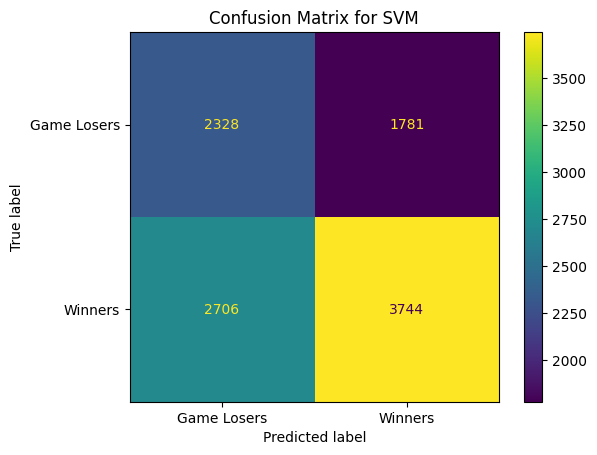

Y_pred is  [0 0 1 ... 0 1 0]
The cross tab is  col_0     0     1
row_0            
0      2328  1781
1      2706  3744
              precision    recall  f1-score   support

           0       0.46      0.57      0.51      4109
           1       0.68      0.58      0.63      6450

    accuracy                           0.58     10559
   macro avg       0.57      0.57      0.57     10559
weighted avg       0.59      0.58      0.58     10559



In [23]:
from sklearn.svm import LinearSVC

h1 = LinearSVC(C=100,penalty='l2', class_weight={0: 1.5, 1:1})
h1.fit(X_train,y_train)
h1.score(X_train,y_train)

# predict data and cross tab
y_pred = h1.predict(X_test)
pd.crosstab(y_test, y_pred)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# show a confusion matrix
confusion_matrix_1 = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix_1, display_labels=["Game Losers", "Winners"]
)
cm_display.plot()
plt.title("Confusion Matrix for SVM")
plt.show()

# shows the classification results by cross tabing the prediction vs the test
print("Y_pred is ", y_pred)
print("The cross tab is ", pd.crosstab(y_test, y_pred))
print(classification_report(y_test, y_pred))
# print("The next classification report is ", classification_report(y_test, y_pred_2) )
# print("The best estimator is ",h1.best_estimator_)
# print("The best params is ",h1.best_params_)


# Build Tuned Model

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import make_scorer, recall_score

param_grid = {
    'C': range(1,100,10),
    'gamma': (1,20,5),
    'kernel': ['linear']
}

# Create an SVM model
svm = SVC()

# Choose the scoring method
# For recall:
scorer = make_scorer(recall_score,pos_label=1.0)

# For F1 Score:
# scorer = make_scorer(f1_score)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring="recall",cv=2,verbose=2, n_jobs=5)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 2 folds for each of 30 candidates, totalling 60 fits


KeyboardInterrupt: 

# Model Evaluation

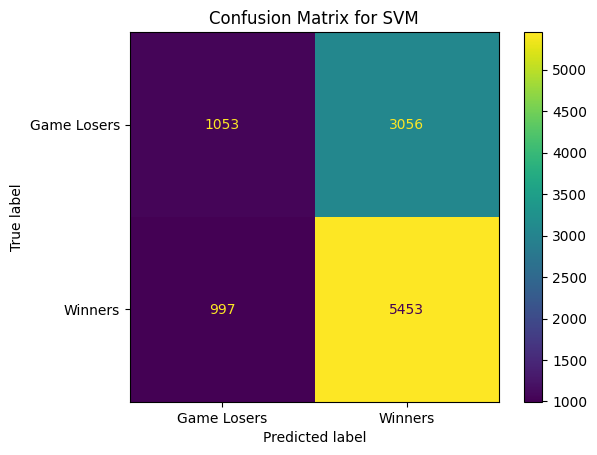

Y_pred is  [0 1 1 ... 0 1 1]
The cross tab is  col_0     0     1
row_0            
0      1053  3056
1       997  5453
              precision    recall  f1-score   support

           0       0.51      0.26      0.34      4109
           1       0.64      0.85      0.73      6450

    accuracy                           0.62     10559
   macro avg       0.58      0.55      0.54     10559
weighted avg       0.59      0.62      0.58     10559



In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# show a confusion matrix
confusion_matrix_1 = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix_1, display_labels=["Game Losers", "Winners"]
)
cm_display.plot()
plt.title("Confusion Matrix for SVM")
plt.show()

# shows the classification results by cross tabing the prediction vs the test
print("Y_pred is ", y_pred)
print("The cross tab is ", pd.crosstab(y_test, y_pred))
print(classification_report(y_test, y_pred))
# print("The next classification report is ", classification_report(y_test, y_pred_2) )
# print("The best estimator is ",h1.best_estimator_)
# print("The best params is ",h1.best_params_)
